In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from matplotlib import colors
from IPython.display import clear_output
import time
from scipy.signal import convolve2d
from scipy.ndimage import median_filter
import math

In [166]:
class env:
    def __init__(self, id, x_range, y_range):
        self.id = id
        self.cx, self.cy = (x_range[0]+x_range[1])/2, (y_range[0]+y_range[1])/2
        self.r = min(abs(x_range[0]-x_range[1]), abs(y_range[0]-y_range[1]))

    def forward(self, payload, u=None):
        assert self.id == payload["takim_numarasi"]
        
        if u is None:
#             if (self.cx - payload["iha_enlem"])> self.r or (self.cy - payload["iha_boylam"])> self.r:
#                 payload["iha_yonelme"] += -180
#             else:
            payload["iha_yonelme"] += np.random.randint(-20, 21)
            rad = np.deg2rad(payload["iha_yonelme"])
        else:
            
            payload["iha_yonelme"] = u
            rad = np.deg2rad(u)
            
        
        vx = abs(np.random.normal(0, 0.05))
        vy = abs(np.random.normal(0, 0.05))
        
        payload["iha_enlem"] += np.random.normal(0, 0.005) + vx * np.sin(rad)
        payload["iha_boylam"] += np.random.normal(0, 0.005)  + vy * np.cos(rad)
        payload["iha_irtifa"] += np.random.normal(0, 0.1)
        
        payload["iha_dikilme"] += np.random.normal(0, 0.1)
        payload["iha_yatis"] += np.random.normal(0, 0.1)
        
        payload["zaman_farki"] += np.random.normal(0, 0.1)
        return payload

In [167]:
def plot_arrow(pos):
    rad = np.deg2rad(pos["iha_yonelme"])
    arrow_end_x = pos["iha_enlem"] + 0.1 * np.sin(rad)
    arrow_end_y = pos["iha_boylam"] + 0.1 * np.cos(rad)
    plt.arrow(pos["iha_enlem"], pos["iha_boylam"], arrow_end_x - pos["iha_enlem"], arrow_end_y - pos["iha_boylam"], 
          head_width=0.03, head_length=0.05, fc='red', ec='red')

def plot_text(your_pos, pos):
    if your_pos["iha_irtifa"] == pos["iha_irtifa"]:
        p = ""
    elif your_pos["iha_irtifa"] < pos["iha_irtifa"]:
        p = " +"
    else:
        p = " -"
    plt.text(pos["iha_enlem"], pos["iha_boylam"], str(pos["takim_numarasi"])+p)

def plot_point(pos_array):
    for pos in pos_array:
        plt.plot(pos[0], pos[1], 'ro')

def plot_line(pos_array):
    pos_array = np.array(pos_array)
    plt.plot(pos_array[:, 0], pos_array[:, 1])

In [168]:
class generate_map:
    
    def __init__(self, id, lat_range, lon_range, points):
        self.id = id
        self.std_dev = 1
        self.lat_range = lat_range
        self.lon_range = lon_range
        y = np.linspace(lat_range[0], lat_range[1], int((lat_range[1]-lat_range[0])/0.01))
        x = np.linspace(lon_range[0], lon_range[1], int((lon_range[1]-lon_range[0])/0.01))
        
        self.lat, self.lon = np.meshgrid(y, x)
        self.contour = np.zeros(self.lat.shape)
        self.cache = dict()

        n = 30
        for i in range(n):
            self.contour[i, i:-i-1] = 10/(i+1)
            self.contour[-(1+i), i:-i] = 10/(i+1)
            self.contour[i:-i-1, i] = 10/(i+1)
            self.contour[i:-i-1, -(1+i)] = 10/(i+1)
        self.contour[-1] = 10
        
        
        for (x, y) in points:
            self.contour += np.exp(-((self.lat-x)**2 + (self.lon-y)**2) / (2 * self.std_dev))

        self.contour = np.clip(self.contour, -1, 1)



    def update(self, telem):
        contour = self.contour.copy()
        for pos in telem["konumBilgileri"]:
            self.history(pos)
            if pos["takim_numarasi"] != self.id:
                contour -= np.exp(-((self.lat-pos["iha_enlem"])**2 + (self.lon-pos["iha_boylam"])**2) / (2 * self.std_dev/2)) 
            else:
                your_pos = pos
        return contour, your_pos

    def history(self, pos):
        if pos["takim_numarasi"] not in self.cache:
            self.cache[pos["takim_numarasi"]] = deque([[pos["iha_enlem"], pos["iha_boylam"]]], maxlen=10)
        else:
            self.cache[pos["takim_numarasi"]].append([pos["iha_enlem"], pos["iha_boylam"]])

In [169]:
def is_within_trim_distance(pos1, pos2, trim):
    return abs(pos2["iha_enlem"] - pos1["iha_enlem"]) < trim and abs(pos2["iha_boylam"] - pos1["iha_boylam"]) < trim

def is_within_test_range(pos, lat_range, lon_range):
    return lat_range[0] < pos["iha_enlem"] < lat_range[1] and lon_range[0] < pos["iha_boylam"] < lon_range[1]

def should_plot(pos, your_pos, env, trim):
    within_trim_distance = trim != 0 and is_within_trim_distance(pos, your_pos, trim)
    within_test_range = trim == 0 and is_within_test_range(pos, env.lat_range, env.lon_range)
    return within_test_range or within_trim_distance

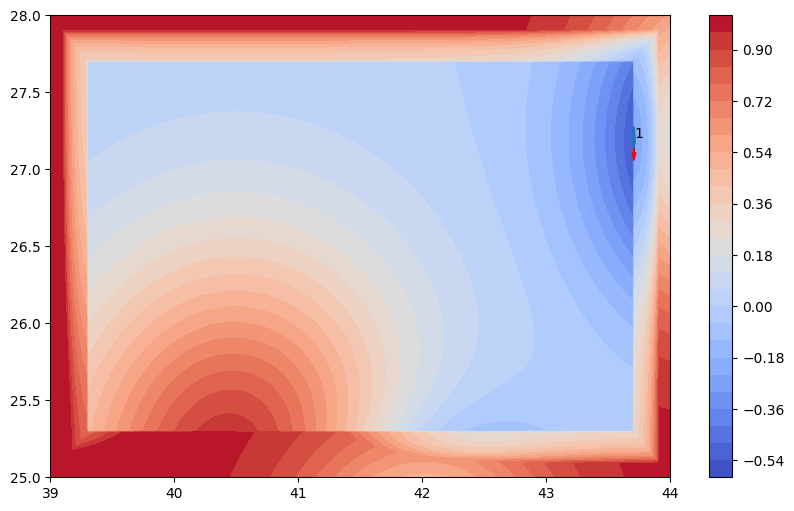

In [ ]:


x_range = [39, 44]
y_range = [25, 28]

uav1 = env(1, x_range, y_range)
uav2 = env(2, x_range, y_range)
uav3 = env(3, x_range, y_range)
uav4 = env(4, x_range, y_range)

payload1 = {
            "takim_numarasi": 1,
            "iha_enlem": np.random.uniform(*x_range),
            "iha_boylam": np.random.uniform(*y_range),
            "iha_irtifa": 25,
            "iha_dikilme": 200,
            "iha_yonelme": 270,
            "iha_yatis": 0,
            "zaman_farki": 93
        }


payload2 = {
            "takim_numarasi": 2,
            "iha_enlem": np.random.uniform(*x_range),
            "iha_boylam": np.random.uniform(*y_range),
            "iha_irtifa": 25,
            "iha_dikilme": 0,
            "iha_yonelme": 90,
            "iha_yatis": 0,
            "zaman_farki": 74
        }


payload3 = {
            "takim_numarasi": 3,
            "iha_enlem": np.random.uniform(*x_range),
            "iha_boylam": np.random.uniform(*y_range),
            "iha_irtifa": 25,
            "iha_dikilme": 5,
            "iha_yonelme": 180,
            "iha_yatis":4,
            "zaman_farki": 43
        }

payload4 = {
            "takim_numarasi": 4,
            "iha_enlem": np.random.uniform(*x_range),
            "iha_boylam": np.random.uniform(*y_range),
            "iha_irtifa": 28,
            "iha_dikilme": 5,
            "iha_yonelme": 180,
            "iha_yatis":4,
            "zaman_farki": 43
        }

test = generate_map(1, [39, 44], [25, 28], [(40.5, 25)])
trim = 0
u = 0

kernel = np.array([[-1, -2, 1], [0, 0, 0], [1, 2, 1]])
for i in range(1000):
    payload1 = uav1.forward(payload1, u)
    payload2 = uav2.forward(payload2)
    payload3 = uav3.forward(payload3)
    payload4 = uav4.forward(payload4)
    
    
    telem = {"sunucuSaati": {
        "saat": 6,
        "dakika": 53,
        "saniye": 42,
        "milisaniye": 500
    }, "konumBilgileri" : [payload1, payload2, payload3, payload4]}

    
    contour, your_pos = test.update(telem)
    ind = pos_to_ind(test.lon, test.lat, your_pos)
    u = gradient_descent(contour, ind, 10, 3)
    
    clear_output(wait=True)
    
    plt.figure(figsize=((np.array(contour.shape[::-1])//50).tolist()))
    cp = plt.contourf(test.lat, test.lon, contour, cmap='coolwarm', levels=25)
    plt.colorbar(cp)
    for pos in telem["konumBilgileri"]:
        if should_plot(pos, your_pos, test, trim):
            plot_text(your_pos, pos)
            plot_line(test.cache[pos["takim_numarasi"]])
            plot_arrow(pos)
    if trim:
        plt.xlim(your_pos["iha_enlem"]-trim, your_pos["iha_enlem"]+trim)
        plt.ylim(your_pos["iha_boylam"]-trim, your_pos["iha_boylam"]+trim)

    plt.show()
    time.sleep(1)

In [246]:
180+45

225

5 -5 10 0


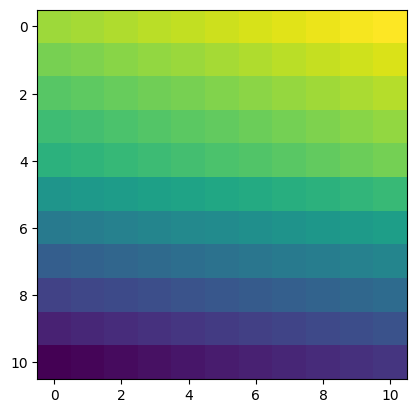

In [21]:
map, rad = gradient_descent(contour, ind, 10, 3)

In [85]:
import numpy as np
import random
import math

# Matris boyutları
width, height = 10, 10

# Matrisin merkezini hesapla
center_x, center_y = width // 2, height // 2

# Rastgele bir nokta seç
random_x = random.randint(0, width-1)
random_y = random.randint(0, height-1)
print(random_y, random_x)
# Seçilen noktanın merkeze göre açısını hesapla (radyan cinsinden)
angle_radians = math.atan2(random_y - center_y, random_x - center_x)

# Açıyı derece cinsine çevir
angle_degrees = math.degrees(angle_radians)

print(f"Rastgele seçilen nokta: ({random_x}, {random_y})")
print(f"Merkez noktası: ({center_x}, {center_y})")
print(f"Açı (radyan): {angle_radians}")
print(f"Açı (derece): {angle_degrees}")


8 0
Rastgele seçilen nokta: (0, 8)
Merkez noktası: (5, 5)
Açı (radyan): 2.601173153319209
Açı (derece): 149.03624346792648


In [78]:
math.degrees(math.atan(5/-5))

-45.0

In [164]:
import numpy as np

# Sample 2D matrix
matrix = np.array([
    [1, 1, 3],
    [1, 2, 1],
    [1, 1, 0]
])

# Step 1: Find the index of the smallest value
y, x = np.unravel_index(np.argmin(matrix), matrix.shape)

# Step 2: Calculate the center point
length, width = matrix.shape
center_y, center_x = length // 2, width // 2

# Step 3: Calculate the angle in radians
delta_y = y - center_y
delta_x = x - center_x
# Adjust calculation to make north 0 degrees and increase clockwise
# Swap delta_y and delta_x and invert delta_x to rotate our reference frame
angle_radians_adjusted = np.arctan2(delta_x, -delta_y)

# Convert angle from radians to degrees
angle_degrees_adjusted = np.degrees(angle_radians_adjusted)

# Ensure angle is positive and in the range [0, 360)
angle_degrees_adjusted = angle_degrees_adjusted % 360

angle_degrees_adjusted

135.0

In [87]:
90+45

135

In [33]:
np.rad2deg(np.arctan2(5, -5))

135.0

In [252]:
def pos_to_ind(lon, lat, your_pos):
    y = np.argmin(abs(test.lon[:, 0] - your_pos["iha_boylam"]))
    x = np.argmin(abs(test.lat[0, :] - your_pos["iha_enlem"]))
    return (y, x)

def gradient_descent(matrix, start_point, window_size, kernel_size):
    window = matrix[start_point[0]-window_size:start_point[0]+window_size, start_point[1]-window_size:start_point[1]+window_size:]
    y, x = np.unravel_index(np.argmin(window), window.shape)
    length, width = window.shape
    center_y, center_x = length // 2, width // 2
    delta_y = y - center_y
    delta_x = x - center_x
    # Adjust calculation to make north 0 degrees and increase clockwise
    # Swap delta_y and delta_x and invert delta_x to rotate our reference frame
    angle_radians_adjusted = np.arctan2(delta_x, delta_y)
    angle_degrees_adjusted = np.degrees(angle_radians_adjusted)
    return angle_degrees_adjusted % 360
    

(20, 20)


225.0

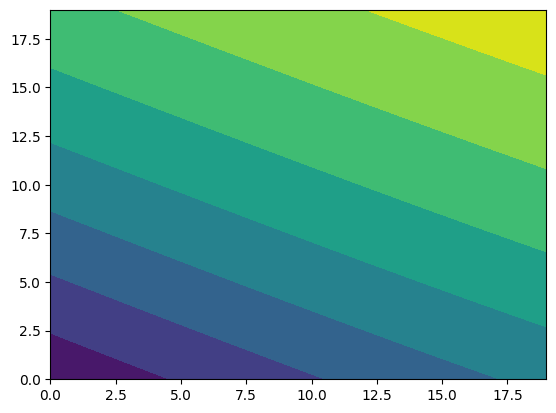

In [250]:
gradient_descent(contour, ind, 10, 3)

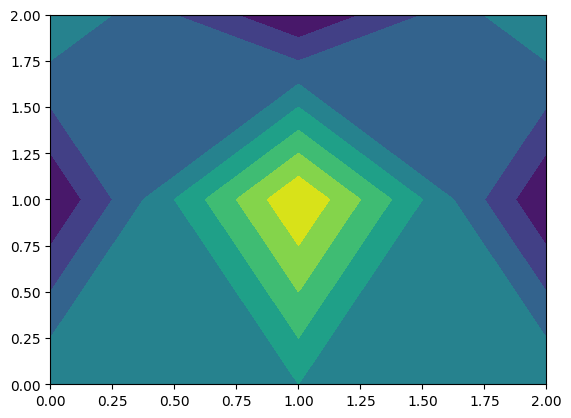

In [234]:
plt.contourf(matrix)

In [215]:
gradient_descent(matrix, (1, 1), 4, 3)

[[1 0 3]
 [1 2 1]
 [1 1 1]]


0.0